# Introduction:

The intent of this EDA is to investigate the impact of each recorded characteristic on the overall adoption speed. Specifically, the goal is to explore the relationships between each variable and adoption speed. 

The PetFinder Malaysia dataset investigation will hopefully yield insights that can be applied to the pet catalog of a local shelter to increase pet adoptions overall by adjusting online pet profiles. 

The datasets utilized in this notebook were cleaned and generated in the data wrangling portion of this project, details of which can be found here: [Github Link: Data_Wrangling.ipynb](https://github.com/CJEJansson/Springboard_Projects/blob/master/Capstone%201/Data_Wrangling/Data_Wrangling.ipynb)

# The Data:

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from functools import reduce

In [2]:
#Import Data Sets

#File Names
adoptfile  = 'tidy_data/adoption_speed.csv'
colorfile  = 'tidy_data/color_labels.csv'
wormfile   = 'tidy_data/dewormed.csv'
breedfile  = 'tidy_data/dog_breeds.csv'
datafile   = 'tidy_data/dog_data.csv'
furfile    = 'tidy_data/fur_length.csv'
healthfile = 'tidy_data/health.csv'
sizefile   = 'tidy_data/size.csv'
statefile  = 'tidy_data/state_labels.csv'
fixedfile  = 'tidy_data/sterilized.csv'
vacfile    = 'tidy_data/vaccine.csv'

#Import Files
adptspeed  = pd.read_csv(adoptfile)
color      = pd.read_csv(colorfile)
dewormed   = pd.read_csv(wormfile)
breeds     = pd.read_csv(breedfile)
dog_data   = pd.read_csv(datafile)
fur_length = pd.read_csv(furfile)
health     = pd.read_csv(healthfile)
adult_size = pd.read_csv(sizefile)
state=pd.read_csv(statefile)
fixed = pd.read_csv(fixedfile)
vaccinated = pd.read_csv(vacfile)

#### The data set variables are defined in the column variables of the data set, which can be found via the code below:

In [3]:
#General information about the data
dog_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10230 entries, 0 to 10229
Data columns (total 26 columns):
index            10230 non-null int64
Name             7238 non-null object
Age              10230 non-null int64
Breed1           10230 non-null int64
Breed2           10230 non-null int64
BreedCount       10230 non-null int64
Gender           10230 non-null int64
Color1           10230 non-null int64
Color2           10230 non-null int64
Color3           10230 non-null int64
ColorCount       10230 non-null int64
MaturitySize     10230 non-null int64
FurLength        10230 non-null int64
Vaccinated       10230 non-null int64
Dewormed         10230 non-null int64
Sterilized       10230 non-null int64
Health           10230 non-null int64
Quantity         10230 non-null int64
Fee              10230 non-null int64
State            10230 non-null int64
RescuerID        10230 non-null object
VideoAmt         10230 non-null int64
Description      10196 non-null object
PetID          

In [4]:
#Coulmn names of dataset
dog_data.columns

Index(['index', 'Name', 'Age', 'Breed1', 'Breed2', 'BreedCount', 'Gender',
       'Color1', 'Color2', 'Color3', 'ColorCount', 'MaturitySize', 'FurLength',
       'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee',
       'State', 'RescuerID', 'VideoAmt', 'Description', 'PetID', 'PhotoAmt',
       'AdoptionSpeed'],
      dtype='object')

## The characteristics of each listing are as follows:
 
 - Animal Specific
    - Name
    - Age (in months)
    - Breed 
    - Gender (M/F or "mixed" for multipet listings)
    - Color
    - Adult size
    - Fur Length
    - Health: Vacinnations, Dewormed, Sterilized, known Injuries/Illness
    
 - Listing Specific
    - Number of pets in listing
    - Presence and number of photos/videos
    - Animal location (State)
    - Organization (Rescuer ID)
    - Adoption Fee (0=Free)
    - Description
    

# Exploratory Data Analysis:

We will begin by investigating the distribution of adoption speeds in the dataset. Once this is understood, an investigation will be performed to try and determine the impacts of the following on adoption speed: 

1.  Name
    - presence vs. absence
2.  Age
2.  Breed
    - type of breed
    - mixed vs. pure breed
3.  Gender
4.  Color
    - specific color
    - multicolor vs single color (color count)
5.  Size at maturity
6.  Fur Length
7.  General health
    - has the animal been dewormed?
    - has the animal been vaccinated?
    - has the animal been spayed/neutered?
    - does the animal have any injuries/known health problems?
8.  Number of pets per listing
9.  Adoption fee
    - cost to adopt
    - paid vs free
10. Location
11. Rescue Organization
12. Media
    - number of videos
    - presence/absence of videos
    - number of photos
    - presence/absence of photos

Age was not addressed during data wrangling, and so a column to address life stages of the dogs will need to be added to the data for exploratory analysis. Typical age grouping for dogs is as follows: 

- Puppy: 0-6 months
- Adolescent: 6-18 months
- Adult: 18+ months
- Senior:
  - Small Dogs: 10-12 years (120-144 months)
  - Medium Dogs: 9-11 years (108-132 months)
  - Large Dogs: 8-10 years (96 -120 months)
  - Giant Dogs: 5-7 years (60-84 months)
  
For the purposes of this data the cut offs will be defined as follows for "senior" animals

- Small: 11 years (132 months)
- Medium: 10 years (120 months)
- Large : 9 years (108 months)
- Giant: 8 years (96 months)

Let's add a column for the life stage of the animal, "lifestage". 

In [5]:
#Initalize an empty list
lf_stg = []

for index in dog_data.index:
    #Clear dummy variable
    a=''
    
    #If age <=6 months, puppy
    if dog_data['Age'][index] <= 6:
        a='puppy'
    #If age between 6-18 mo, Adolescent/young adult
    elif dog_data['Age'][index] <=18:
        a='adolescent'
    else:
        if dog_data['MaturitySize'][index] == 1:
            if dog_data['Age'][index] < 132:
                a='adult'
            else:
                a='senior'
        elif dog_data['MaturitySize'][index] == 2:
            if dog_data['Age'][index] < 120:
                a='adult'
            else:
                a='senior'
        elif dog_data['MaturitySize'][index] == 3:
            if dog_data['Age'][index] < 108:
                a='adult'
            else:
                a='senior'
        elif dog_data['MaturitySize'][index] == 4:
            if dog_data['Age'][index] < 96:
                a='adult'
            else:
                a='senior'
    
    lf_stg.append(a)

#Find index of Age position and add 1 to define position for new column
lf_stg_posn = dog_data.columns.get_loc('Age') + 1

#Insert calculated values as new column
dog_data.insert(lf_stg_posn, "LifeStage" , lf_stg)

#Check counts
dog_data.head()

,index,Name,Age,LifeStage,Breed1,Breed2,BreedCount,Gender,Color1,Color2,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,0,Dannie & Kass [In Penang],12,adolescent,307,0,1,2,2,5,...,1,2,0,41326,e59c106e9912fa30c898976278c2e834,0,Dannie and Kass are mother and daughter. We en...,e02abc8a3,5,NaN
1,1,Precious,36,adult,76,307,2,2,7,0,...,1,1,0,41324,6f73a23fdb52bc9a30dc788fe6ccc7f6,0,"Hi, i have a dalmamation mix female dog to giv...",a3787f15e,9,NaN
2,2,Angel,24,adult,307,307,1,2,5,7,...,1,1,0,41324,6f73a23fdb52bc9a30dc788fe6ccc7f6,0,found a stray female dog who follows my mum ca...,0113cedff,3,NaN
3,3,NaN,12,adolescent,307,307,1,2,2,3,...,1,2,0,41324,6f73a23fdb52bc9a30dc788fe6ccc7f6,0,both female dogs r thrown away at d food court...,0070b950a,4,NaN
4,4,NaN,3,puppy,218,307,2,1,1,7,...,1,1,0,41324,6f73a23fdb52bc9a30dc788fe6ccc7f6,1,"Hi, im liew here.. Im not sure how is this don...",cbe2df167,0,NaN


In [6]:
#Export Data to CSV for later use, if needed
dog_data.to_csv(r'tidy_data/dog_data_WLStage.csv',index=False)

In [7]:
#Split into 2 data sets, test, train, for ease of analysis
dogs_train = dog_data[dog_data.AdoptionSpeed.notnull()]
dogs_test = dog_data[dog_data.AdoptionSpeed.isnull()]

In [8]:
#Return the modified column names after the addition of Life Stage
dog_data.columns

Index(['index', 'Name', 'Age', 'LifeStage', 'Breed1', 'Breed2', 'BreedCount',
       'Gender', 'Color1', 'Color2', 'Color3', 'ColorCount', 'MaturitySize',
       'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health',
       'Quantity', 'Fee', 'State', 'RescuerID', 'VideoAmt', 'Description',
       'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

## Animal Location

There are 10,230 dogs in the provided dataset.Of these, the animals are distributed throughout the country of Malaysia. The data is categorized by Malaysian state. If you are unfamiliar with Malaysia, a map of the states can be seen below. 

![alt text](Imgs/States.png "Malaysian States")
(http://www.wonderfulmalaysia.com/map-maps-malaysia.htm)

A count of the animals available in each state can be seen below. It's likely that state will affect adoption speed, solely based on the number of animals available in each state. 

Text(0.5,1,'Dog Breeds By State')

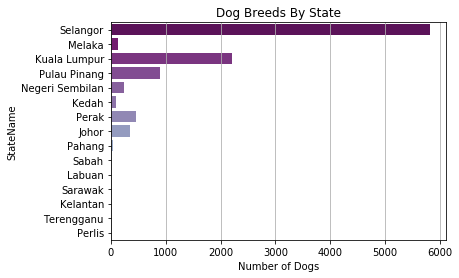

In [9]:
#Combine List of States with the Dog Dataframe to determine number of dogs in each state
state_data = dog_data.merge(state,how='outer',left_on='State',right_on='StateID')

#Create plot
plt.figure()
c = sns.countplot(y='StateName', data=state_data, palette= 'BuPu_r')
plt.grid(b=None, which='major', axis='x')
plt.xlabel("Number of Dogs")
plt.title('Dog Breeds By State')

## Adoption Speed Distribution

There are 10,230 dogs in the provided dataset. Of those dogs, the adoption rate distribution is as follows: 

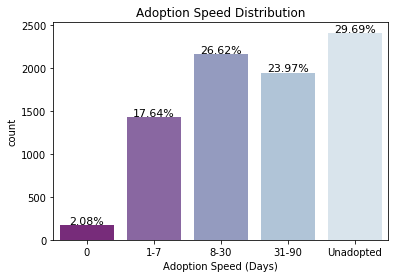

In [10]:
#Define x-axis labels
adpt_spd = adptspeed.AdoptionSpeed

#Create Plot
plt.figure()
c = sns.countplot(x='AdoptionSpeed', data=dogs_train, palette= 'BuPu_r')
plt.xticks([0,1,2,3,4], adpt_spd)
plt.xlabel('Adoption Speed (Days)')
plt.title ('Adoption Speed Distribution')

#Add percentages above columns 
ax=c.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / dogs_train.shape[0]:.2f}%", 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='k', rotation=0, xytext=(0, 4),
                 textcoords='offset points')

It looks like adoption speed is fairly evenly distributed, with the exception of dogs adopted same day as listing. This makes logical sense, as it's pretty unlikely for a dog to be adopted the same day unless someone is watching for the specific animal. 

Unfortunately, the majority of pets, approximately 24%, were not adopted at all. There is some amount of chance in an animal being seen by the right person at the right time, but let's investigate further to see if there are any other factors influencing the adoption speed. 

# Adoption Speed and Age

Let's look first at the ages of the available animals to determine if that has an impact on Adoption Speed.

In [11]:
#Pull only Lifestage information from train dataset
age_data = dogs_train.loc[:,['LifeStage','AdoptionSpeed']]
adptspd= [0,1,2,3,4]

#Separate data by lifestage and insert a column for adoption speed to use to join later
puppies = pd.DataFrame(age_data[age_data.LifeStage=='puppy'].groupby(['AdoptionSpeed']).size(),columns=['Puppies'])
puppies = puppies/puppies.sum()
puppies.insert(0,'AdptSpd',adptspd)

adolescents = pd.DataFrame(age_data[age_data.LifeStage=='adolescent'].groupby(['AdoptionSpeed']).size(),columns=['Adolescents'])
adolescents = adolescents/adolescents.sum()
adolescents.insert(0,'AdptSpd',adptspd)

adults = pd.DataFrame(age_data[age_data.LifeStage=='adult'].groupby(['AdoptionSpeed']).size(),columns=['Adults'])
adults = adults/adults.sum()
adults.insert(0,'AdptSpd',adptspd)

seniors = pd.DataFrame(age_data[age_data.LifeStage=='senior'].groupby(['AdoptionSpeed']).size(),columns=['Seniors'])
seniors = seniors/seniors.sum()
seniors.insert(0,'AdptSpd',adptspd[1:])

#Create one life stage dataframe 
age_frames = [puppies,adolescents,adults,seniors]
age_merged = reduce(lambda  left,right: pd.merge(left,right,on=['AdptSpd'],
                                            how='outer'), age_frames)
age_merged


,AdptSpd,Puppies,Adolescents,Adults,Seniors
0,0,0.017393,0.028759,0.026172,NaN
1,1,0.189985,0.122432,0.174680,0.105263
2,2,0.298930,0.207067,0.208764,0.131579
3,3,0.254014,0.211175,0.216677,0.184211
4,4,0.239679,0.430567,0.373707,0.578947


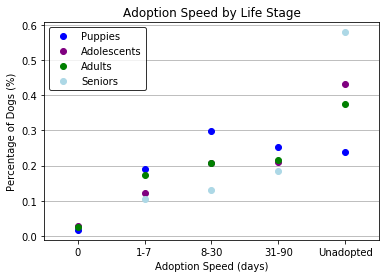

In [62]:
#Plot Distributions of Adoption Speed vs Life Stage 

#Drop AdptSpd Column from Dataframe
ages = age_merged.iloc[:,1:]

#Define x-axis labels
adpt_spd = adptspeed.AdoptionSpeed
xval = np.arange(len(adpt_spd))

#Create Plot
ages.plot.line(color=['blue','purple','green','lightblue'],linestyle='none',marker='o')
plt.grid(b=None, which='major', axis='y')
plt.xlabel('Adoption Speed (days)')
plt.xlim([-.5,4.5])
plt.ylabel('Percentage of Dogs (%)')
plt.title('Adoption Speed by Life Stage')
plt.xticks(xval,adpt_spd)
plt.legend(loc='upper left',edgecolor='k')


Puppies are certainly adopted the fastest, and seniors the slowest. It appears that adults are adopted at a slightly faster rate than adolescents. So age definitely plays a role in adoption speed. 

# Adoption Speed and Name

There are many pets with given names on their adoption profiles. Does the presence or absence of a name in the listing effect adoption speed?

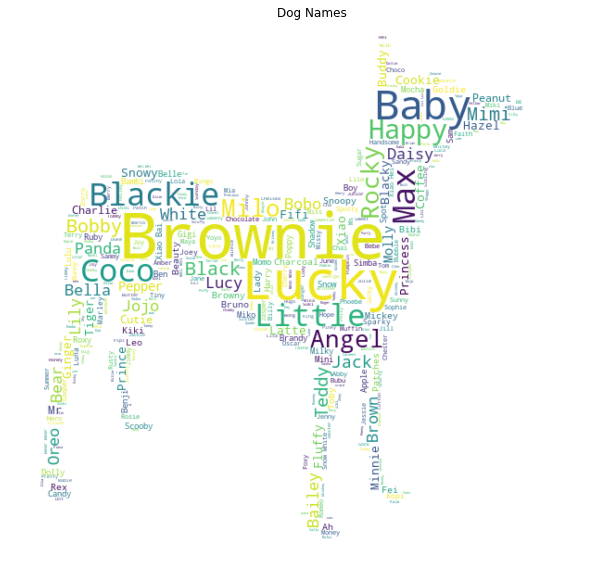

In [13]:
#Define name list
names = ' '.join(dog_data.Name.fillna('').values)

#Assign mask for final word cloud shape
dogmask = np.array(Image.open("Imgs/dog_stand.png"))

#Create word cloud
cloud= WordCloud(background_color="white", max_words=1000, mask=dogmask,
                 contour_color='black').generate(names)
plt.figure(figsize=[10,10])
plt.imshow(cloud,interpolation='bilinear')
plt.title('Dog Names')
plt.axis("off")
plt.show()


#Save word cloud for reports
WordCloud.to_file(cloud,"Imgs/names_cloud.png")

Now let's look at the distribution of named vs. unnamed animals. 

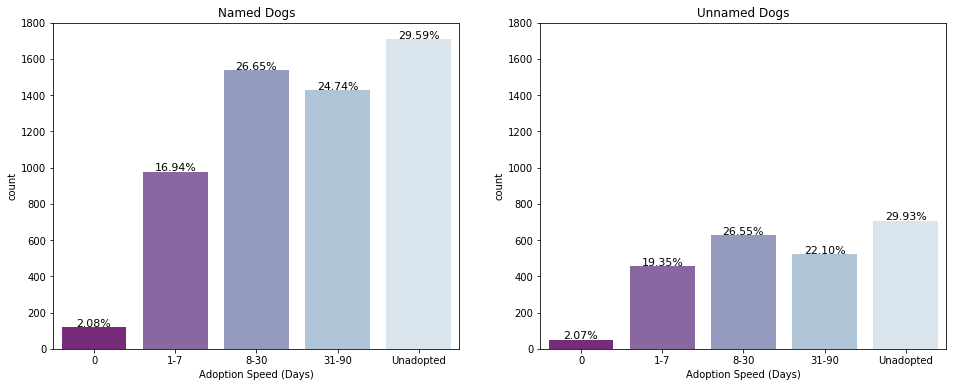

In [14]:
#Define data sets 
named = dogs_train[dogs_train.Name.notnull()]
unnamed = dogs_train[dogs_train.Name.isnull()]
adpt_spd = adptspeed.AdoptionSpeed

#Create Figure with 2 subplots
fig, ax = plt.subplots(figsize = (16, 6))

#Plot Named dog data
plt.subplot(1, 2, 1)
c = sns.countplot(x='AdoptionSpeed', data=named, palette= 'BuPu_r')
plt.xticks([0,1,2,3,4], adpt_spd) 
plt.ylim([0,1800])
plt.xlabel('Adoption Speed (Days)')
plt.title ('Named Dogs')

#Percentages above named dog data
ax=c.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / named.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='k', rotation=0, xytext=(0, 4),
         textcoords='offset points')


#Plot unnamed dog data
plt.subplot(1, 2, 2)
c = sns.countplot(x='AdoptionSpeed', data=unnamed, palette= 'BuPu_r')
plt.xticks([0,1,2,3,4], adpt_spd)
plt.xlabel('Adoption Speed (Days)')
plt.ylim([0,1800])
plt.title ('Unnamed Dogs')

#Percentages above unnamed dog data
ax=c.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / unnamed.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='k', rotation=0, xytext=(0, 4),
         textcoords='offset points')

It appears that dogs without names are adopted faster in the first week, but only by a marginal rate. Overall, dogs with names tend to be adopted faster. Overall it is unlikely that there is much effect on adoption speed if the dog is named or not. 

| Adoption Speed | Named (%) | Unnamed (%)|
| --- | --- | --- |
| Same Day| 2.08| 2.07|
| 1-7 days| 16.94| 19.35 |
| 8-30 days| 26.65| 26.55 |
| 31-90 days| 24.74| 22.10 |
| Not Adopted| 29.59| 29.93 |

# Adoption Speed and Breed
Now let's look at how breed relates to adoption speed. 
Which animals are adopted faster, mixed breeds, or purebreeds?

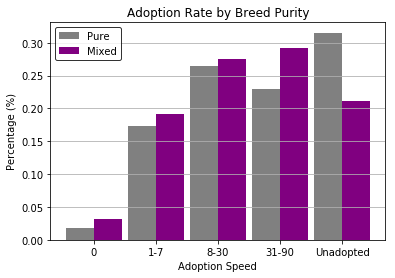

In [63]:
#Separate into data sets for mixed and pure breed animals 
pure = dogs_train[dogs_train.BreedCount==1]
pdata = pd.DataFrame(pure.groupby('AdoptionSpeed').size())
p_norm=pdata/sum(pdata[0])

mixed = dogs_train[dogs_train.BreedCount==2]
mdata = pd.DataFrame(mixed.groupby('AdoptionSpeed').size())
m_norm=mdata/sum(mdata[0])

#Define x-axis labels
adpt_spd = adptspeed.AdoptionSpeed
x = np.arange(len(adpt_spd))
width = 0.45

#Create Plot
fig, ax = plt.subplots()
breeds1 = plt.bar(x -width/2, p_norm[0], width, label='Pure', color='grey')
breeds2 = ax.bar(x + width/2, m_norm[0], width, label='Mixed', color ='purple')

plt.grid(b=None, which='major', axis='y')
plt.xlabel('Adoption Speed')
ax.set_ylabel('Percentage (%)')
ax.set_title('Adoption Rate by Breed Purity')
ax.set_xticks(x)
ax.set_xticklabels(adpt_spd)
ax.legend(edgecolor='k')

In [16]:
#Summarize pure vs mixed percentages 
pure_ttl = len(pure)#sum(pdata[0])
mix_ttl = len(mixed) #sum(mdata[0])
ttl_dgs = pure_ttl + mix_ttl
pct_pure = (pure_ttl/ttl_dgs)*100
pct_mix = (mix_ttl/ttl_dgs)*100

print('Number of Pure Dogs:  ', pure_ttl)
print('Number of Mixed Dogs: ', mix_ttl)
print('Percent Pure Dogs:    ', str(round(pct_pure, 2)), '%')
print('Percent Mixed Dogs:   ', str(round(pct_mix, 2)), '%')

Number of Pure Dogs:   6705
Number of Mixed Dogs:  1425
Percent Pure Dogs:     82.47 %
Percent Mixed Dogs:    17.53 %


Mixed breed dogs appear to be adopted faster than "pure" breed dogs. This is not due to the portion of the dataset comprised of each, as 82% of the dataset are classified as pure breed animals. 


What are the most popular breeds? 

In [17]:
#Combine breed file and data set to list breeds by name rather than categorical value
breed_data = dog_data.iloc[:,4:6]
breed_melt = pd.melt(breed_data, value_name='BreedID')
breed_melt = breed_melt[breed_melt.BreedID != 0]
breed_melt
breed_named = breed_melt.merge(breeds,how='outer',left_on='BreedID', right_on='BreedID')

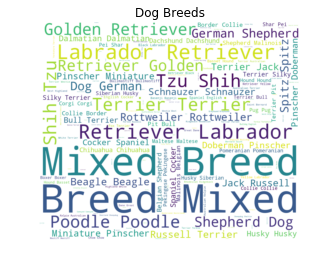

In [18]:
#Create Word Cloud for breed names
breed_names = ' '.join(breed_named.BreedName.fillna('').values)
cloud= WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(breed_names)
plt.imshow(cloud,interpolation='bilinear')
plt.title('Dog Breeds')
plt.axis("off")
plt.show()

Looks Like Breed Mixed and Mixed Breed are the most dominant values returned. People must be using those as classifiers when they're unsure of the breeds. Let's drop those values and recreate the word cloud. Then we'll need to go back and recalculate adoption speeds for mixed vs pure breed dogs. 

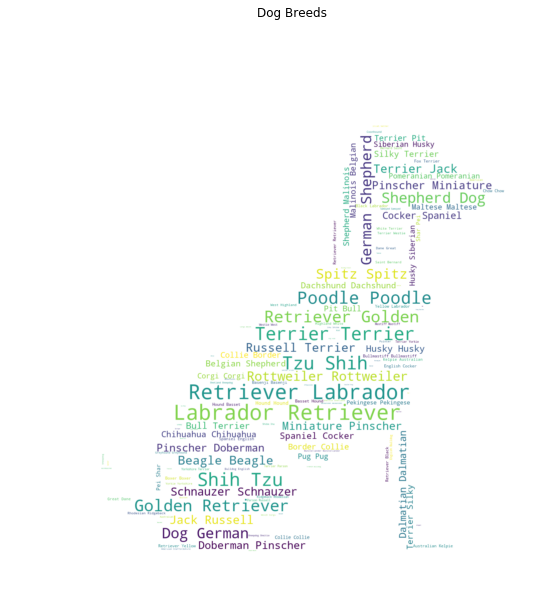

In [19]:
#Drop "breed mixed" and "mixed breed" from list of dog breeds
breed_named2 = breed_named[breed_named.BreedID != 307]
breed_names2 = ' '.join(breed_named2.BreedName.fillna('').values)

#Assign photo to mask for final word cloud shape
breedmask = np.array(Image.open("Imgs/dog_sit_b.png"))

#Create word cloud
cloud2= WordCloud(max_font_size=None, background_color='white', mask=breedmask,
                 width=1200, height=1000).generate(breed_names2)
plt.figure(figsize=(10,10))
plt.imshow(cloud2,interpolation='bilinear')
plt.title('Dog Breeds')
plt.axis("off")
plt.show()

#Save word cloud to file for report use
WordCloud.to_file(cloud2,"Imgs/breeds_cloud.png")

Text(0.5,1,'Most Common Dog Breeds in Data Set')

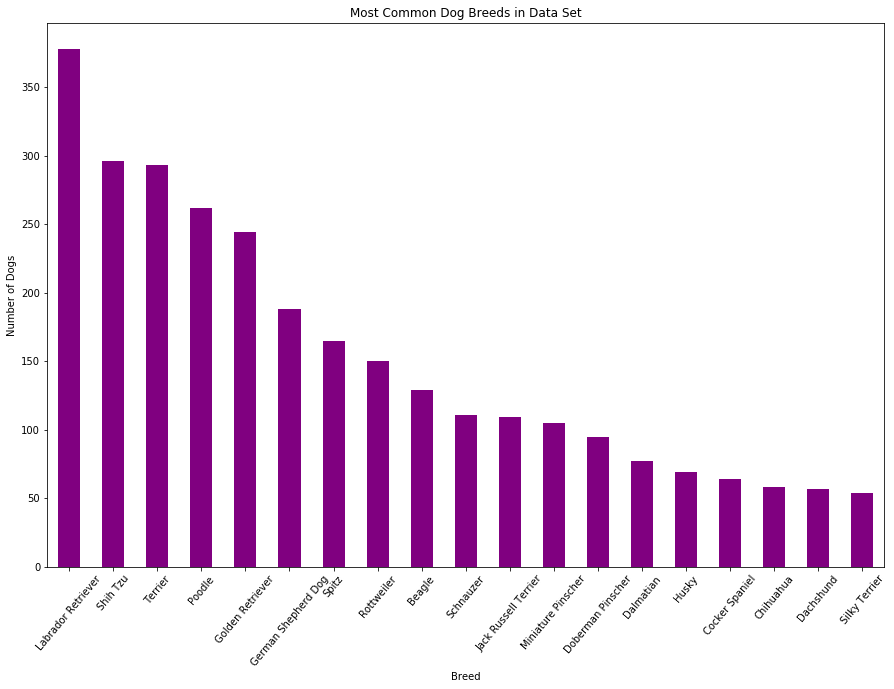

In [20]:
#Count number of dogs of each breed
breed_list = breed_named2.groupby('BreedName').count()

#Remove breeds where there are less than 50 dogs present
breed_list2 = breed_list[breed_list.variable>50]

#Create Plot
plt.figure(figsize=(15,10))
breed_list2.BreedID.sort_values(ascending=False).plot.bar(color='purple')
plt.xticks(rotation=50)
plt.xlabel("Breed")
plt.ylabel("Number of Dogs")
plt.title('Most Common Dog Breeds in Data Set')


It appears that Labradors and Shih Tzu's are the most common dogs in the data set. The third most common is "terrier", which could be any number of dogs breeds and is pretty unspecific.

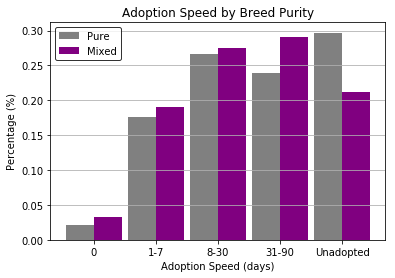

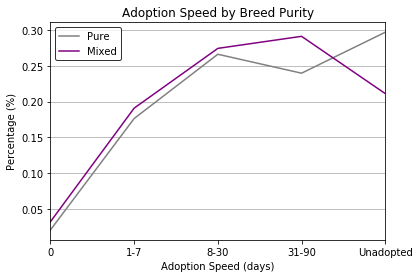

In [64]:
#Separate data into mixed and pure for comparison of adoption speeds
mixed2 = dogs_train[(dogs_train.BreedCount==2) | (dogs_train.Breed1==307) | (dogs_train.Breed2==307)]
mdata2 = pd.DataFrame(mixed.groupby('AdoptionSpeed').size())
m_norm2 = mdata2/sum(mdata2[0])

pure2 = dogs_train[(dogs_train.BreedCount==1) | (dogs_train.Breed1!=307) | (dogs_train.Breed2!=307)]
pdata2 = pd.DataFrame(pure2.groupby('AdoptionSpeed').size())
p_norm2=pdata2/sum(pdata2[0])

#Define x-axis values
adpt_spd = adptspeed.AdoptionSpeed           
x2 = np.arange(len(adpt_spd))
width2 = 0.45

#Create Bar Plot
breeds3 = plt.bar(x2 -width2/2, p_norm2[0], width2, label='Pure', color='grey',linestyle='-')
breeds4 = plt.bar(x2 + width2/2, m_norm2[0], width2, label='Mixed', color ='purple')
plt.grid(b=None, which='major', axis='y')
plt.xlabel('Adoption Speed (days)')
plt.ylabel('Percentage (%)')
plt.title('Adoption Speed by Breed Purity')
plt.xticks(x,adpt_spd)
plt.legend(edgecolor='k')


#Create Line Plot
d_breed = {'Pure': p_norm2[0],'Mixed': m_norm2[0]}
df_breed = pd.DataFrame(d_breed)
df_breed.plot.line(color = ['grey', 'purple'])
plt.grid(b=None, which='major', axis='y')
plt.xlabel('Adoption Speed (days)')
plt.ylabel('Percentage (%)')
plt.title('Adoption Speed by Breed Purity')
plt.xticks(x,adpt_spd )
plt.legend(edgecolor='k')

Mixed breed dogs are clearly more likely to get adopted than pure breed dogs, based on this data set. 

# Adoption Speed and Adult Size

Lets look at the expected adult size of the animal (MaturitySize) in the data set and see if they have any effect on adoption speed. 

How many dogs are there in each size group? 

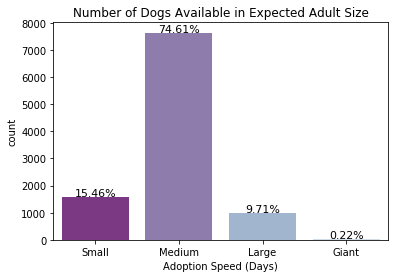

In [22]:
#Create countplot 
plt.figure()
c = sns.countplot(x='MaturitySize', data=dog_data, palette= 'BuPu_r')
plt.xticks([0,1,2,3], adult_size.Size)
plt.xlabel('Adoption Speed (Days)')
plt.title ('Number of Dogs Available in Expected Adult Size')

#Percentages of animals by size above bars
ax=c.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / dog_data.MaturitySize.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='k', rotation=0, xytext=(0, 4),
         textcoords='offset points')

In [23]:
#Pull Size Data
size_db = dogs_train.loc[:,['Name','MaturitySize','AdoptionSpeed']]
size_config = size_db.groupby(['MaturitySize','AdoptionSpeed']).size()
adptspd= [0,1,2,3,4]

#Create 4 subframes given grouped data
#Normalize Size Counts to Percentages and add column on which to merge "AdptSpd"
size1 = pd.DataFrame(size_config[1]/size_config[1].sum(),columns=['Small'])
size1.insert(0,'AdptSpd',adptspd)

size2 = pd.DataFrame(size_config[2]/size_config[2].sum(),columns=['Medium'])
size2['AdptSpd'] = size2.index

size3 = pd.DataFrame(size_config[3]/size_config[3].sum(),columns=['Large'])
size3['AdptSpd'] = size3.index

size4 = pd.DataFrame(size_config[4]/size_config[4].sum(),columns=['Giant'])
size4['AdptSpd'] = size4.index

#Combine 4 subframes
size_frames = [size1,size2,size3,size4]
size_merged = reduce(lambda  left,right: pd.merge(left,right,on=['AdptSpd'],
                                            how='outer'), size_frames)
size_merged

,AdptSpd,Small,Medium,Large,Giant
0,0,0.040883,0.016000,0.027632,NaN
1,1,0.231398,0.159510,0.221053,0.272727
2,2,0.253475,0.269714,0.252632,0.454545
3,3,0.200327,0.251592,0.206579,0.272727
4,4,0.273917,0.303184,0.292105,NaN


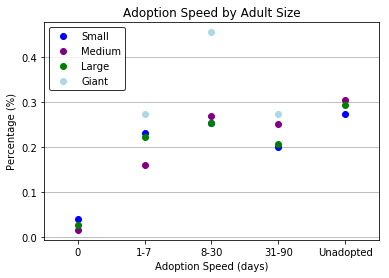

In [65]:
#define x-axis values
adpt_spd = adptspeed.AdoptionSpeed
x3 = np.arange(len(adpt_spd))

#Drop AdptSpd Column
sizes = size_merged.iloc[:,1:]

#Create Plot
sizes.plot.line(color=['blue','purple','green','lightblue'],linestyle='none',marker='o')
plt.grid(b=None, which='major', axis='y')
plt.xlabel('Adoption Speed (days)')
plt.xlim([-.5,4.5])
plt.ylabel('Percentage (%)')
plt.title('Adoption Speed by Adult Size')
plt.xticks(x3,adpt_spd)
plt.legend(loc='upper left',edgecolor='k')


It appears that all giant breed dogs are adopted, with none going unadopted. The bulk of those animals being adopted within a month. However, these values are possibly obscuring some information about the other three breeds. Let's look without the giant dogs and see if a trend becomes clear. 

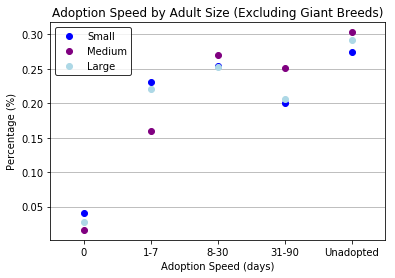

In [66]:
#Define x-axis labels
adpt_spd = adptspeed.AdoptionSpeed
x3 = np.arange(len(adpt_spd))

#Drop giant animals
sizes_no_giant = size_merged.iloc[:,1:4]

#Create Plot
sizes_no_giant.plot.line(color=['blue','purple','lightblue'],linestyle='none',marker='o')
plt.grid(b=None, which='major', axis='y')
plt.xlabel('Adoption Speed (days)')
plt.xlim([-.5,4.5])
plt.ylabel('Percentage (%)')
plt.title('Adoption Speed by Adult Size (Excluding Giant Breeds)')
plt.xticks(x3,adpt_spd )
plt.legend(edgecolor='k')


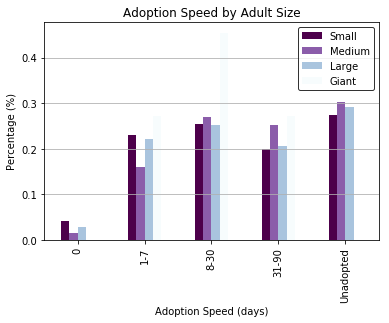

In [67]:
#Define x-axis labels
adpt_spd = adptspeed.AdoptionSpeed
x3 = np.arange(len(adpt_spd))

#Pull all size animals to create bar plot
sizes = size_merged.iloc[:,1:]

#Create Plot
sizes.plot.bar(cmap='BuPu_r')
plt.grid(b=None, which='major', axis='y')
plt.xlabel('Adoption Speed (days)')
plt.ylabel('Percentage (%)')
plt.title('Adoption Speed by Adult Size')
plt.xticks(x3,adpt_spd)
plt.legend(edgecolor='k')

So, it appears that maturity size has little effect on adoption speed, unless you're a giant dog. As there are fewer giant breeds in the data set, it's possible that their scarcity makes them a higher demand animal, resulting in all giant breeds being adopted. 

# Adoption Speed and Coat

Now let's look at the coat of each animal to determine if there's an effect on adoption speed. 

First, lets look at fur length to determine:
1. The number of animals with each fur length and;
2. Whether fur length impacts adoption speed. 

Then, let's see if the dog's fur color impacts adoption speed.  

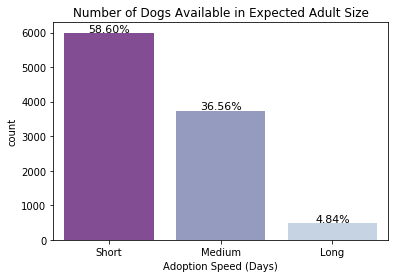

In [27]:
#Create count plot of number of animals of each fur length 
plt.figure()
c = sns.countplot(x='FurLength', data=dog_data, palette= 'BuPu_r')
plt.xticks([0,1,2], fur_length.Length)
plt.xlabel('Adoption Speed (Days)')
plt.title ('Number of Dogs Available in Expected Adult Size')

#Percentages above bars
ax=c.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / dog_data.FurLength.shape[0]:.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=11, color='k', rotation=0, xytext=(0, 4),
         textcoords='offset points')

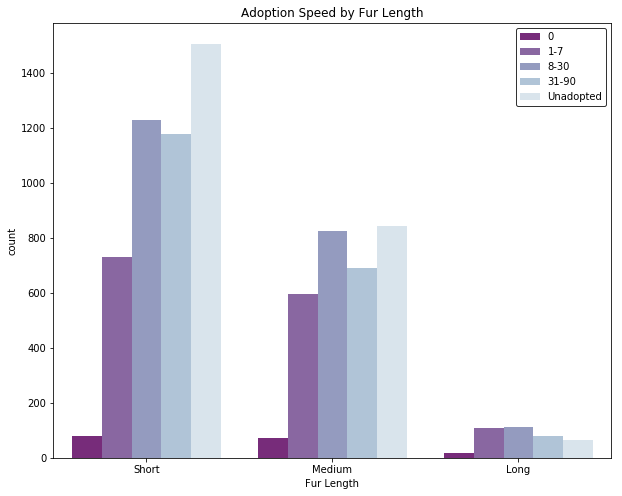

In [68]:
#Create count plot of adoption speeds based on fur length 
plt.figure(figsize=[10,8])
c = sns.countplot(x='FurLength', data=dog_data, hue='AdoptionSpeed', palette= 'BuPu_r')
plt.xticks([0,1,2], fur_length.Length)
plt.xlabel('Fur Length')
plt.title ('Adoption Speed by Fur Length')
plt.legend(adptspeed.AdoptionSpeed,edgecolor='k')


The adoption speed distribution is similarly shaped reguardless of fur length. It's not clear if there's any effect. 

Let's now look at the color distribution of the animals in the data set. Based on those names, there would be no surprise if the majority of the dogs in this data set are brown or black. 

First we'll examine the adoption distribution based on the number of colors a dog is classified as having in it's coat.

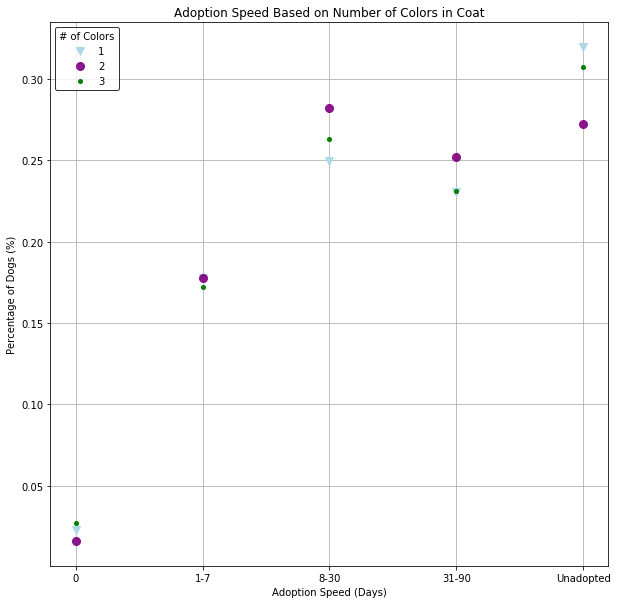

In [71]:
#Create dataframe with only #of colors in the coat and adoption speed
coat_colors = dogs_train.loc[:,['ColorCount','AdoptionSpeed']]

#Break into 3 series and count number of animals in each adoption speed class 
one_color = coat_colors[coat_colors.ColorCount==1].groupby(['AdoptionSpeed']).size()
two_color = coat_colors[coat_colors.ColorCount==2].groupby(['AdoptionSpeed']).size()
three_color = coat_colors[coat_colors.ColorCount==3].groupby(['AdoptionSpeed']).size()

#Define x-axis labels 
adpt_spd = adptspeed.AdoptionSpeed

#Plot comparisons - normalized by # of dogs in each group
plt.figure(figsize=[10,10])

plt.plot(adpt_spd,one_color/sum(one_color),label='1',color='lightblue',linestyle='none',
         marker='v',markersize=8)
plt.plot(adpt_spd,two_color/sum(two_color),label='2',color='purple',linestyle='none',
         marker='o',markersize=8,alpha=.9)
plt.plot(adpt_spd,three_color/sum(three_color),label='3',color='green',linestyle='none',
         marker='.',markersize=8)

plt.grid(b=None, which='major')
plt.xlabel('Adoption Speed (Days)')
plt.ylabel('Percentage of Dogs (%)')
plt.title('Adoption Speed Based on Number of Colors in Coat')
plt.legend(title='# of Colors',edgecolor='k')
plt.show()

There's no clear correlation between the numbers of color in an animals coat and adoption speed. 


Let's now examine the animals colors and if there is an impact on adoption speed. 

In [46]:
#Extract columns with color data and adoption speed
raw_color_data = dogs_train.loc[:,['Color1','Color2','Color3','AdoptionSpeed']]

#Melt colors into one column and map color names from colors table
c = pd.melt(raw_color_data, id_vars='AdoptionSpeed', value_vars=['Color1','Color2','Color3'], value_name='Color')
color_names = c.merge(color,how='outer',left_on='Color',right_on='ColorID')

#Drop Null Values
color_names = color_names.dropna()

#Return unique color names
color_names.ColorName.unique()

array(['Brown', 'Black', 'Gray', 'Cream', 'White', 'Golden', 'Yellow'],
      dtype=object)

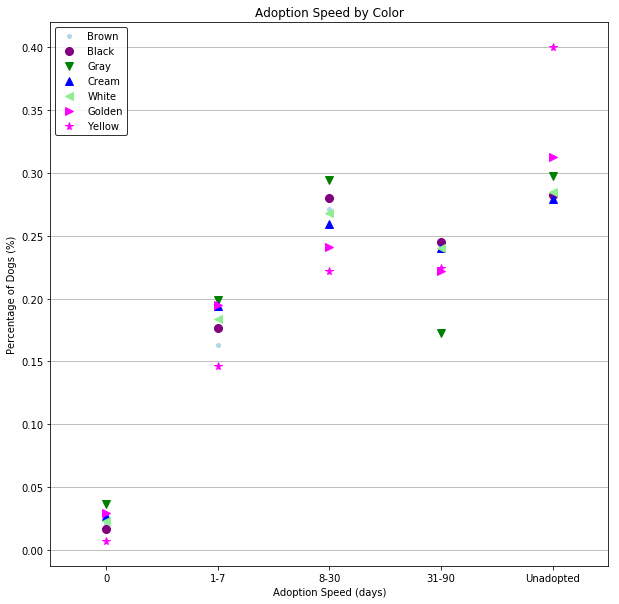

In [93]:
#Pull only plot data from color_names 
color_data = color_names.loc[:,['AdoptionSpeed','ColorName']]

brown = color_data[color_data.ColorName == 'Brown'].groupby(['AdoptionSpeed']).size()
ttl_brown = brown.sum()

black = color_data[color_data.ColorName == 'Black'].groupby(['AdoptionSpeed']).size()
ttl_blk = black.sum()

gray = color_data[color_data.ColorName == 'Gray'].groupby(['AdoptionSpeed']).size()
ttl_gry = gray.sum()

cream = color_data[color_data.ColorName == 'Cream'].groupby(['AdoptionSpeed']).size()
ttl_crm = cream.sum()

white = color_data[color_data.ColorName == 'White'].groupby(['AdoptionSpeed']).size()
ttl_wht = white.sum()

golden = color_data[color_data.ColorName == 'Golden'].groupby(['AdoptionSpeed']).size()
ttl_gld = golden.sum()

yellow = color_data[color_data.ColorName == 'Yellow'].groupby(['AdoptionSpeed']).size()
ttl_yllw = yellow.sum()

# pd.DataFrame(age_data[age_data.LifeStage=='puppy'].groupby(['AdoptionSpeed']).size(),columns=['Puppies'])

#Define x-axis labels
adpt_spd = adptspeed.AdoptionSpeed
xval = np.arange(len(adpt_spd))

#Create Plot
plt.figure(figsize=[10,10])

plt.plot(adpt_spd,brown/ttl_brown,label='Brown',color='lightblue',linestyle='none',
         marker='.',markersize=8)
plt.plot(adpt_spd,black/ttl_blk,label='Black',color='purple',linestyle='none',
         marker='o',markersize=8)
plt.plot(adpt_spd,gray/ttl_gry,label='Gray',color='green',linestyle='none',
         marker='v',markersize=8)
plt.plot(adpt_spd,cream/ttl_crm,label='Cream',color='blue',linestyle='none',
         marker='^',markersize=8)
plt.plot(adpt_spd,white/ttl_wht,label='White',color='lightgreen',linestyle='none',
         marker='<',markersize=8)
plt.plot(adpt_spd,golden/ttl_gld,label='Golden',color='fuchsia',linestyle='none',
         marker='>',markersize=8)
plt.plot(adpt_spd,yellow/ttl_yllw,label='Yellow',color='magenta',linestyle='none',
         marker='*',markersize=8)



plt.grid(b=None, which='major', axis='y')
plt.xlabel('Adoption Speed (days)')
plt.xlim([-.5,4.5])
plt.ylabel('Percentage of Dogs (%)')
plt.title('Adoption Speed by Color')
plt.xticks(xval,adpt_spd)
plt.legend(edgecolor='k')#loc='upper left',edgecolor='k')

# Adoption Speed and Listing Settings 

The listings are done in different styles. Some have multiple pets per listing, while others don't. Some charge a fee to adopt the animal. Some include photos and videos, while others don't. What's the impact of these choices? Particularly since this will be one of the easiest area to make adjustments that may increase the likelihood of adoption. 

### Quantity of Pets per Listing

Does the quantity of pets per listing have any effect on adoption speed? 

Let's start by only looking at listings with one pet, as these will be the most common, then compare the resulting distributions to see if theres any noticeable difference based on the number of pets. 

In [300]:
#Complete list of different options for numbers of dogs per listing 
dog_data.Quantity.unique()

array([ 2,  1,  6,  7,  3,  4,  5, 14, 13, 10, 11,  9,  8, 19, 20, 12, 17,
       16, 15])

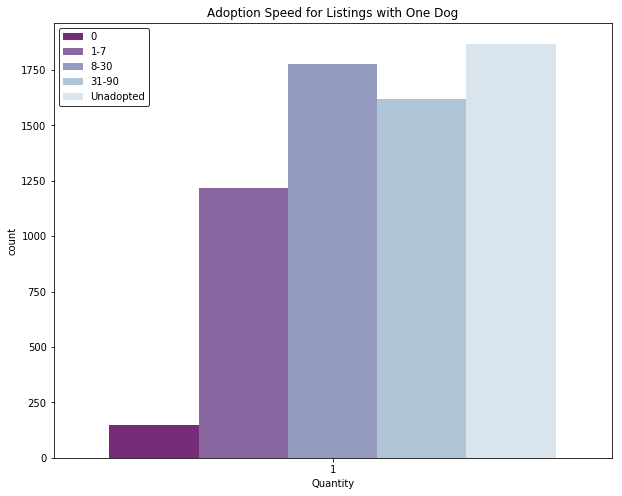

In [34]:
#Pull data for listings with one dog
onedog=dog_data[dog_data.Quantity ==1]

#Create plot for adoption speed by listings with 1 dog
plt.figure(figsize=[10,8])
c = sns.countplot(x='Quantity', data=onedog, hue='AdoptionSpeed', palette= 'BuPu_r')
plt.title ('Adoption Speed for Listings with One Dog')
plt.legend(adptspeed.AdoptionSpeed,edgecolor='k')


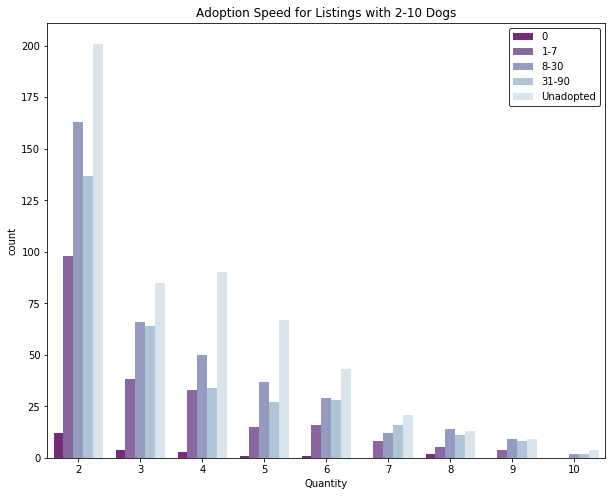

In [38]:
#Pull data for listings with two to 10 dogs
multidog2_10=dog_data[(dog_data.Quantity > 1) & (dog_data.Quantity <= 10)]

#Create Plot
plt.figure(figsize=[10,8])
c = sns.countplot(x='Quantity', data=multidog2_10, hue='AdoptionSpeed', palette= 'BuPu_r')
plt.title ('Adoption Speed for Listings with 2-10 Dogs')
plt.legend(adptspeed.AdoptionSpeed, loc='upper right',edgecolor='k')


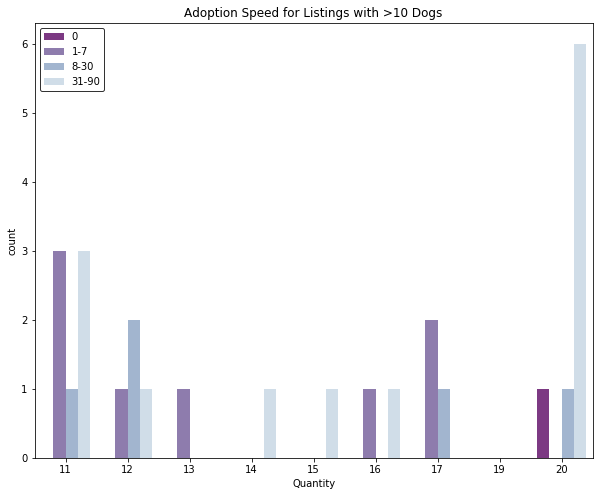

In [39]:
#Pull data for listings with 10+ dogs
multidog11up=dog_data[(dog_data.Quantity > 10)]

#Create Plot
plt.figure(figsize=[10,8])
c = sns.countplot(x='Quantity', data=multidog11up, hue='AdoptionSpeed', palette= 'BuPu_r')
plt.title ('Adoption Speed for Listings with >10 Dogs')
plt.legend(adptspeed.AdoptionSpeed, loc='upper left',edgecolor='k')

It appears that the number of dogs per listing does impact adoption speed. Listings with more dogs take longer for the dogs to be adopted, on average

### Use of Photos and/or Videos

Some listings include photos or vidos of the animals. Does the ability to get an impression of the dog have an effect on adoption speed? It's likely that a photo makes a big difference, but what about videos? 

In [41]:
#Create Photo presence/absence dataframe
adptspd= [0,1,2,3,4]
adpt_spd=adptspeed.AdoptionSpeed

photos_present=dog_data[(dog_data.PhotoAmt > 0)]
pp_2 = pd.DataFrame(photos_present.groupby('AdoptionSpeed').size())
pp_norm = pp_2/sum(pp_2[0])
pp_norm.insert(0,'AdptSpd',adptspd)

photos_absent = dog_data[(dog_data.PhotoAmt == 0)]
pa_2 = pd.DataFrame(photos_absent.groupby('AdoptionSpeed').size())
pa_norm = pa_2/sum(pa_2[0])
pa_norm.insert(0,'AdptSpd',adptspd)

photos = pp_norm.merge(pa_norm,how='outer',left_on='AdptSpd',right_on='AdptSpd')
photos.columns = ['AdptSpd','Present','Absent']
photo_use = photos.iloc[:,1:]

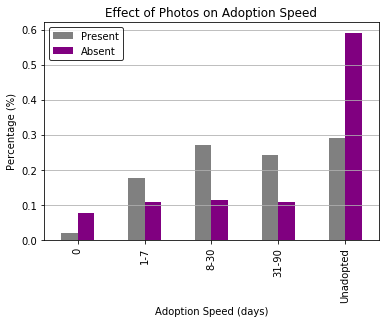

In [42]:
#Define x-axis labels
adpt_spd = adptspeed.AdoptionSpeed
x = np.arange(len(adpt_spd))

#Create plot
photo_use.plot.bar(color = ['grey', 'purple'])
plt.grid(b=None, which='major', axis='y')
plt.xticks(x,adpt_spd)
plt.xlabel('Adoption Speed (days)')
plt.ylabel('Percentage (%)')
plt.title('Effect of Photos on Adoption Speed')
plt.legend(edgecolor='k')

In [43]:
#Create video presence/absence dataframe
adptspd= [0,1,2,3,4]

videos_present = dog_data[(dog_data.VideoAmt > 0)]
vp_2 = pd.DataFrame(videos_present.groupby('AdoptionSpeed').size())
vp_norm = vp_2/sum(vp_2[0])
vp_norm.insert(0,'AdptSpd',adptspd)

videos_absent = dog_data[(dog_data.VideoAmt == 0)]
va_2 = pd.DataFrame(videos_absent.groupby('AdoptionSpeed').size())
va_norm = va_2/sum(va_2[0])
va_norm.insert(0,'AdptSpd',adptspd)

videos = vp_norm.merge(va_norm,how='outer',left_on='AdptSpd',right_on='AdptSpd')
videos.columns = ['AdptSpd','Present','Absent']
video_use = videos.iloc[:,1:]
video_use

,Present,Absent
0,0.038835,0.020074
1,0.119741,0.178622
2,0.265372,0.266206
3,0.300971,0.237310
4,0.275081,0.297788


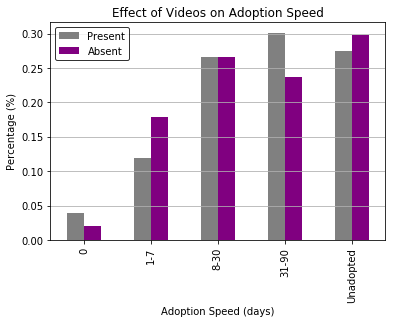

In [44]:
#Define x-axis labels
adpt_spd=adptspeed.AdoptionSpeed
x = np.arange(len(adpt_spd))

#Create Plot
video_use.plot.bar(color = ['grey', 'purple'])
plt.grid(b=None, which='major', axis='y')
plt.xticks(x,adpt_spd)
plt.xlabel('Adoption Speed (days)')
plt.ylabel('Percentage (%)')
plt.title('Effect of Videos on Adoption Speed')
plt.legend(edgecolor='k')

The presence of photos in the listing definitely makes a difference, improving adoption times, as expected. 

The presence of videos doesn't seem to have much effect.

### Adoption Cost

In [54]:
#List of possible fees
fees_data = dog_data.Fee.value_counts()
fees_data

0       8691
50       224
100      206
200      200
150      130
        ... 
290        1
210        1
3000       1
385        1
59         1
Name: Fee, Length: 67, dtype: int64

In [55]:
#Create dataframe containing only fee and adoption speed
dog_fees = dogs_train.loc[:,['Fee','AdoptionSpeed']]

#Find expected range of adoption fees (min-max)
dog_fees.describe()

,Fee,AdoptionSpeed
count,8130.000000,8130.000000
mean,24.300615,2.615621
std,90.095822,1.143737
min,0.000000,0.000000
25%,0.000000,2.000000
50%,0.000000,3.000000
75%,0.000000,4.000000
max,3000.000000,4.000000


In [56]:
#Seperate into free vs dogs that cost money to adopt
dogs_free = dog_fees[dog_fees.Fee == 0]
dogs_cost = dog_fees[dog_fees.Fee > 0]

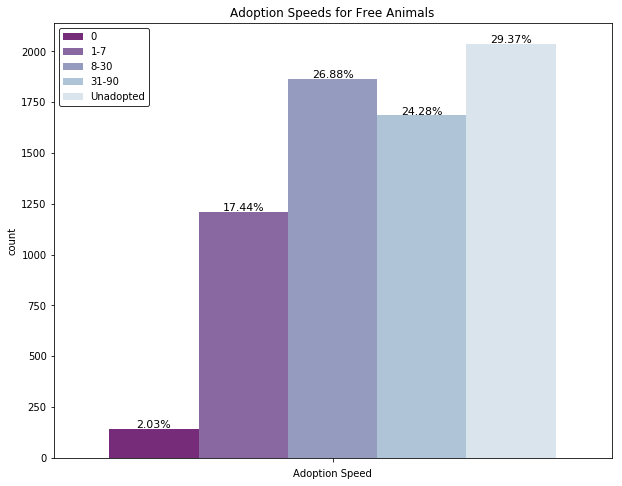

In [57]:
#Define x-axis labels
adpt_spd = adptspeed.AdoptionSpeed

#Create plot
plt.figure(figsize=[10,8])
c = sns.countplot(x='Fee', data=dogs_free, hue='AdoptionSpeed', palette= 'BuPu_r')
plt.xlabel('Adoption Speed')
plt.xticks([0],'')
plt.title ('Adoption Speeds for Free Animals')
plt.legend(adpt_spd,edgecolor='k')

#Percentages above bars
ax=c.axes
for p in ax.patches:
     ax.annotate(f"{p.get_height() * 100 / dogs_free.Fee.shape[0]:.2f}%", 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='k', rotation=0, xytext=(0, 4),
                 textcoords='offset points')


Text(0.5,1,'Adoption Fees')

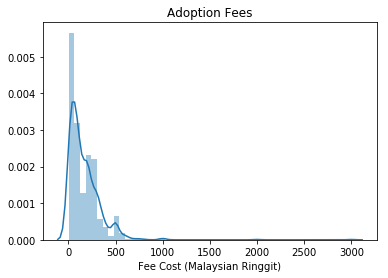

In [58]:
#Create distribution plot to show range of fees 
c = sns.distplot(dogs_cost.Fee)
plt.xlabel('Fee Cost (Malaysian Ringgit)')
plt.title ('Adoption Fees')

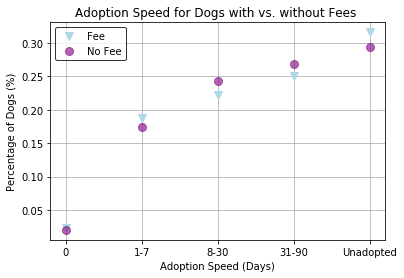

In [64]:
#Define x-axis labels 
adpt_spd = adptspeed.AdoptionSpeed

#Create list of dogs that are free and dogs that are not
fees_speed = dogs_cost.AdoptionSpeed.value_counts().sort_values()
free_speed = dogs_free.AdoptionSpeed.value_counts().sort_values()

#Total number of free and not-free dogs for normalization
fee_ttl = len(dogs_cost)#sum(fees_speed)
free_ttl = len(dogs_free)#sum(free_speed)

#Create Plot
plt.plot(adpt_spd,fees_speed/fee_ttl,label='Fee',color='lightblue',linestyle='none',marker='v',markersize=8)
plt.plot(adpt_spd,free_speed/free_ttl,label='No Fee',color='purple',linestyle='none',marker='o',markersize=8,alpha=.6)
plt.grid(b=None, which='major')
plt.xlabel('Adoption Speed (Days)')
plt.ylabel('Percentage of Dogs (%)')
plt.title('Adoption Speed for Dogs with vs. without Fees ')
plt.legend(edgecolor='k')
plt.show()

It appears that more dogs that cost a fee go unadopted, but overall the impact of adoption cost on adoption speed is low. 

# Adoption Speed and General Health 

The overall health and wellbeing of an animal may also impact adoption speed. The data set includes information on whether an animal is vaccinated, spayed/neutered, has been dewormed, or has another underlying health condition. If a known health condition is present, there's information as to the severity of the problem as well. Let's investigate.

### Vaccination Status

In [52]:
#Create dataframes for health centric metrics
dogs_vac = dogs_train.loc[:,['Vaccinated','AdoptionSpeed']]
dogs_worm = dogs_train.loc[:,['Dewormed','AdoptionSpeed']]
dogs_fixed = dogs_train.loc[:,['Sterilized','AdoptionSpeed']]
dog_health = dogs_train.loc[:,['Health','AdoptionSpeed']]

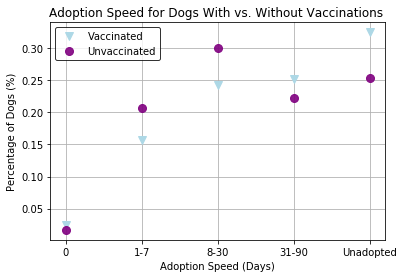

In [53]:
#Define x-axis labels 
adpt_spd = adptspeed.AdoptionSpeed

#Define vaccination status arrays
vac_data = dogs_vac[dogs_vac.Vaccinated==1].groupby(['AdoptionSpeed']).size()
unvac_data = dogs_vac[dogs_vac.Vaccinated==2].groupby(['AdoptionSpeed']).size()
unknownvac_data = dogs_vac[dogs_vac.Vaccinated==3].groupby(['AdoptionSpeed']).size()

#Plot comparison
plt.plot(adpt_spd,vac_data/sum(vac_data),label='Vaccinated',color='lightblue',linestyle='none',
         marker='v',markersize=8)
plt.plot(adpt_spd,unvac_data/sum(unvac_data),label='Unvaccinated',color='purple',linestyle='none',
         marker='o',markersize=8,alpha=.9)
plt.grid(b=None, which='major')
plt.xlabel('Adoption Speed (Days)')
plt.ylabel('Percentage of Dogs (%)')
plt.title('Adoption Speed for Dogs With vs. Without Vaccinations ')
plt.legend(edgecolor='k')
plt.show()

It appears that unvaccinated dogs tend to be adopted sooner. It's possible that this is due to the age of the dogs that are unvaccinated. 

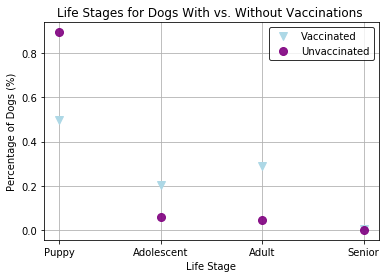

In [54]:
#Create data frame of only life stage and vaccination status 
age_vaccine = dogs_train.loc[:,['Vaccinated','LifeStage']]

#Separate into vaccinated and unvaccinated animals,
#normalize by number of dogs in each group,
#And rearrange for life stage by age instead of alphabetical 

age_vac = age_vaccine[age_vaccine.Vaccinated==1].groupby(['LifeStage']).size()
vac_ttl = sum(age_vac)
age_vac_n = age_vac/vac_ttl
age_vac_ordered = [age_vac_n[2],age_vac_n[0],age_vac_n[1],age_vac_n[3]]


age_unvac = age_vaccine[age_vaccine.Vaccinated==2].groupby(['LifeStage']).size()
unvac_ttl = sum(age_unvac)
age_unvac_n = age_unvac/unvac_ttl
age_unvac_ordered = [age_unvac_n[2],age_unvac_n[0],age_unvac_n[1],age_unvac_n[3]]

#Define x-axis labels
ages = ['Puppy','Adolescent','Adult','Senior']

#Create Plot
plt.plot(ages,age_vac_ordered,label='Vaccinated',color='lightblue',linestyle='none',marker='v',markersize=8)
plt.plot(ages,age_unvac_ordered,label='Unvaccinated',color='purple',linestyle='none',marker='o',markersize=8,alpha=.9)
plt.grid(b=None, which='major')
plt.xlabel('Life Stage')
plt.ylabel('Percentage of Dogs (%)')
plt.title('Life Stages for Dogs With vs. Without Vaccinations ')
plt.legend(edgecolor='k')
plt.show()


Yes, it is obvious that the majority of unvaccinated dogs are puppies, and puppies tend to be adopted the fastest.

There's also a set of data in the vaccination list for dogs where the vaccination status is unknown. Does this have an impact? 

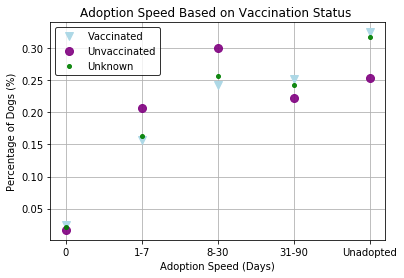

In [55]:
#Add unknown vaccination status animals to plot and replot

plt.plot(adpt_spd,vac_data/sum(vac_data),label='Vaccinated',color='lightblue',linestyle='none',
         marker='v',markersize=8)
plt.plot(adpt_spd,unvac_data/sum(unvac_data),label='Unvaccinated',color='purple',linestyle='none',
         marker='o',markersize=8,alpha=.9)
plt.plot(adpt_spd,unknownvac_data/sum(unknownvac_data),label='Unknown',color='green',linestyle='none',
         marker='.',markersize=8,alpha=.9)

plt.grid(b=None, which='major')
plt.xlabel('Adoption Speed (Days)')
plt.ylabel('Percentage of Dogs (%)')
plt.title('Adoption Speed Based on Vaccination Status ')
plt.legend(edgecolor='k')
plt.show()

Dogs with unknown vaccination status appear to fall directly between the vaccinated and unvaccinated dogs when it comes to adoption speed, with a slight edge over vaccinated dogs. This may again be due to the number of puppies with unknown vaccination status. 

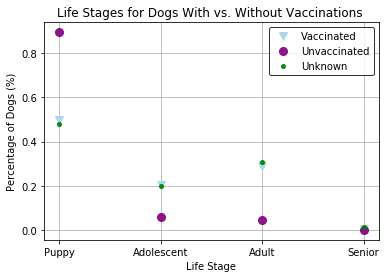

In [56]:
#Create lifestage data for animals of unknown vaccination status
age_unknown_vac = age_vaccine[age_vaccine.Vaccinated==3].groupby(['LifeStage']).size()
unknown_ttl = sum(age_unknown_vac)
age_unknown_vac_n = age_unknown_vac/unknown_ttl
age_unknown_vac_ordered = [age_unknown_vac_n[2],age_unknown_vac_n[0],age_unknown_vac_n[1],age_unknown_vac_n[3]]

#Define x-axis labels
ages = ['Puppy','Adolescent','Adult','Senior']

#Create Plot
plt.plot(ages,age_vac_ordered,label='Vaccinated',color='lightblue',linestyle='none',marker='v',markersize=8)
plt.plot(ages,age_unvac_ordered,label='Unvaccinated',color='purple',linestyle='none',marker='o',markersize=8,
         alpha=.9)
plt.plot(ages,age_unknown_vac_ordered,label='Unknown',color='green',linestyle='none',marker='.',markersize=8,
         alpha=.9)

plt.grid(b=None, which='major')
plt.xlabel('Life Stage')
plt.ylabel('Percentage of Dogs (%)')
plt.title('Life Stages for Dogs With vs. Without Vaccinations ')
plt.legend(edgecolor='k')
plt.show()


Yes, again it appears the effect of unknown vaccination status can be traced to puppies. 

### Reproductive Status (Spayed/Neutered vs. Intact)

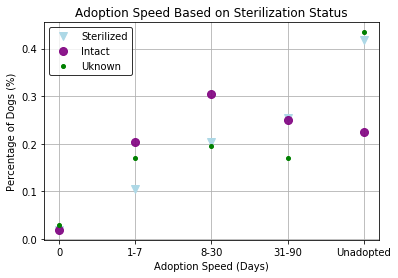

In [57]:
#Define sterilization status arrays
fixed_dogs = dogs_fixed[dogs_fixed.Sterilized==1].groupby(['AdoptionSpeed']).size()
intact_dogs = dogs_fixed[dogs_fixed.Sterilized==2].groupby(['AdoptionSpeed']).size()
uk_fixed = dogs_fixed[dogs_fixed.Sterilized==3].groupby(['AdoptionSpeed']).size()

#Define x-axis labels 
adpt_spd = adptspeed.AdoptionSpeed

#Plot comparison
plt.plot(adpt_spd,fixed_dogs/sum(fixed_dogs),label='Sterilized',color='lightblue',linestyle='none',
         marker='v',markersize=8)
plt.plot(adpt_spd,intact_dogs/sum(intact_dogs),label='Intact',color='purple',linestyle='none',
         marker='o',markersize=8,alpha=.9)
plt.plot(adpt_spd,uk_fixed/sum(uk_fixed),label='Uknown',color='green',linestyle='none',
         marker='.',markersize=8)


plt.grid(b=None, which='major')
plt.xlabel('Adoption Speed (Days)')
plt.ylabel('Percentage of Dogs (%)')
plt.title('Adoption Speed Based on Sterilization Status')
plt.legend(edgecolor='k')
plt.show()

Intact dogs tend to be adopted fastest. This may be due to people wanting to be able to breed their animals. It may also be that sterilized dogs cost more than intact animals. This will be investigated as part of statistical analysis, due in part to the fact that graphical results showed low correlation between adoption cost and adoption speed. 

### Digestive System Health (dewormed or not?)

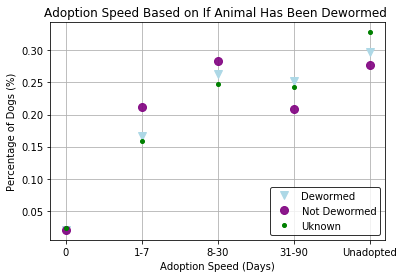

In [58]:
#Define worm status arrays
noworms_dogs = dogs_worm[dogs_worm.Dewormed==1].groupby(['AdoptionSpeed']).size()
worms_dogs = dogs_worm[dogs_worm.Dewormed==2].groupby(['AdoptionSpeed']).size()
uk_worms_dogs = dogs_worm[dogs_worm.Dewormed==3].groupby(['AdoptionSpeed']).size()


#Define x-axis labels 
adpt_spd = adptspeed.AdoptionSpeed

#Plot comparison
plt.plot(adpt_spd,noworms_dogs/sum(noworms_dogs),label='Dewormed',color='lightblue',linestyle='none',
         marker='v',markersize=8)
plt.plot(adpt_spd,worms_dogs/sum(worms_dogs),label='Not Dewormed',color='purple',linestyle='none',
         marker='o',markersize=8,alpha=.9)
plt.plot(adpt_spd,uk_worms_dogs/sum(uk_worms_dogs),label='Uknown',color='green',linestyle='none',
         marker='.',markersize=8)


plt.grid(b=None, which='major')
plt.xlabel('Adoption Speed (Days)')
plt.ylabel('Percentage of Dogs (%)')
plt.title('Adoption Speed Based on If Animal Has Been Dewormed ')
plt.legend(loc='lower right',edgecolor='k')
plt.show()

Dogs that have not been dewormed are dogs that are adopted fastest. Again this is likely due to the age of the dogs,as puppies are typically not dewormed.

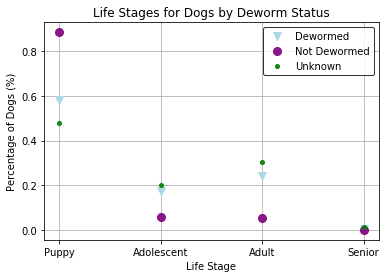

In [59]:
#Create data frame of only life stage and vaccination status 
age_worm = dogs_train.loc[:,['Dewormed','LifeStage']]

#Separate into vaccinated and unvaccinated animals,
#normalize by number of dogs in each group,
#And rearrange for life stage by age instead of alphabetical 

#Dewormed
age_dw = age_worm[dogs_worm.Dewormed==1].groupby(['LifeStage']).size()
dw_ttl = sum(age_dw)
age_dw_n = age_dw/dw_ttl
age_dw_ordered = [age_dw_n[2],age_dw_n[0],age_dw_n[1],age_dw_n[3]]

#Not Dewormed
age_w = age_worm[dogs_worm.Dewormed==2].groupby(['LifeStage']).size()
w_ttl = sum(age_w)
age_w_n = age_w/w_ttl
age_w_ordered = [age_w_n[2],age_w_n[0],age_w_n[1],age_w_n[3]]


#Unknown
age_wuk = age_worm[dogs_worm.Dewormed==3].groupby(['LifeStage']).size()
wuk_ttl = sum(age_wuk)
age_wuk_n = age_wuk/wuk_ttl
age_wuk_ordered = [age_wuk_n[2],age_wuk_n[0],age_wuk_n[1],age_wuk_n[3]]



#Define x-axis labels
ages = ['Puppy','Adolescent','Adult','Senior']

#Create Plot
plt.plot(ages,age_dw_ordered,label='Dewormed',color='lightblue',linestyle='none',marker='v',markersize=8)
plt.plot(ages,age_w_ordered,label='Not Dewormed',color='purple',linestyle='none',marker='o',markersize=8,alpha=.9)
plt.plot(ages,age_wuk_ordered,label='Unknown',color='green',linestyle='none',marker='.',markersize=8, alpha=.9)

plt.grid(b=None, which='major')
plt.xlabel('Life Stage')
plt.ylabel('Percentage of Dogs (%)')
plt.title('Life Stages for Dogs by Deworm Status')
plt.legend(edgecolor='k')
plt.show()

As expected, the majority of dogs that have not been dewormed are puppies. 

### Other Known Health Injuries

In [60]:
#Define Adoption Speed Array
adptspd= [0,1,2,3,4]

#Define health status dataframes and insert adoption speed column for joining 
healthy_dogs = pd.DataFrame(dog_health[dog_health.Health==1].groupby(['AdoptionSpeed']).size(),
                            columns=['Healthy'])
healthy_dogs = healthy_dogs/healthy_dogs.sum()
healthy_dogs.insert(0,'AdptSpd',adptspd)

minor_injury = pd.DataFrame(dog_health[dog_health.Health==2].groupby(['AdoptionSpeed']).size(),
                            columns=['Minor Injury'])
minor_injury = minor_injury/minor_injury.sum()
minor_injury.insert(0,'AdptSpd',adptspd)

major_injury = pd.DataFrame(dog_health[dog_health.Health==3].groupby(['AdoptionSpeed']).size(),
                            columns=['Major Injury'])
major_injury = major_injury/major_injury.sum()
major_injury.insert(0,'AdptSpd',adptspd[1:])

#Create one health status dataframe 
health_frames = [healthy_dogs,minor_injury,major_injury]
health_merged = reduce(lambda  left,right: pd.merge(left,right,on=['AdptSpd'],
                                            how='outer'), health_frames)
health_merged

,AdptSpd,Healthy,Minor Injury,Major Injury
0,0,0.020528,0.030075,NaN
1,1,0.176846,0.172932,0.047619
2,2,0.268010,0.210526,0.285714
3,3,0.241234,0.195489,0.238095
4,4,0.293383,0.390977,0.428571


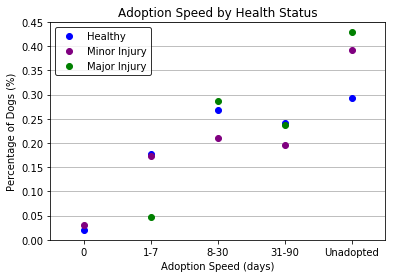

In [61]:
#Plot Distributions of Adoption Speed vs Health Status

#Drop AdptSpd from Dataframe
healths = health_merged.iloc[:,1:]

#Define x-axis labels
adpt_spd = adptspeed.AdoptionSpeed
xval = np.arange(len(adpt_spd))

#Create Plot
healths.plot.line(color=['blue','purple','green','lightblue'],linestyle='none',marker='o')
plt.grid(b=None, which='major', axis='y')
plt.xlabel('Adoption Speed (days)')
plt.xlim([-.5,4.5])
plt.ylabel('Percentage of Dogs (%)')
plt.title('Adoption Speed by Health Status')
plt.xticks(xval,adpt_spd)
plt.legend(loc='upper left',edgecolor='k')


As expected healthy dogs are adopted the fastest, and dogs with major injuries tend to be adopted the slowest. 

# Conclusions

After completing the Exploratory Data Analysis (EDA) of this data set the following conclusions can be drawn, and should be investigated more in depth. This investigation will eventually lead to the development of a model to be used to predict adoption speeds.

- Adoption speed is fairly evenly distributed after the first week, at ~25%
    - Within the first week ~20% are adopted, with the remaining ~5% adopted in the first day. 
- Age plays a large role in adoption speed.
    - Puppies are adopted the fastest, and senior dogs are most likely to go unadopted. 
- Listing the dog with a name doesn't have much impact on adoption speed. 
- Mixed breed dogs are adopted faster that pure breed dogs. 
    - Labradors, Shih Tzu's, and Terriers are the most common breeds available in Malaysia. 
- Size has little effect on adoption speed, unless the animal is a giant breed, due to the low number of available animals in this class. 
- Fur length has little effect on adoption speed. 
- ***** FUR COLOR ******
    - The number of colors in an animals coat does not have much impact, if any, on adoption speed. 
- The way the listing is configured plays a large role in adoption speed:
    - Listings with multiple dogs result in longer adoption times. This may be due to the inability to capture data for each animal adopted causing a skew towards the longer adoption time. 
    - Photos will help increase adoption speed, videos don't have much impact. 
    - Free animals and animals with adoption fees are adopted at approximately the same rate. 
- Health of the animal does play a role in adoption speed:
    - Puppies tend to be unvaccinated and have not been dewormed, and these animals are adopted fastest. 
    - Spayed/Neutered animals are less likely to be adopted than animals that are intact. 
    - Healthy animals are more likely to be adopted than dogs with injury or illness. 